In [1]:
import os
import scvi
import torch
import glob
import anndata
import argparse
import pandas as pd
import numpy as np
import scanpy as sc
import rapids_singlecell as rsc 
import scipy.sparse
import mudata
import genomic_features as gf
from tqdm import tqdm
from typing import Optional, Union, List

device = torch.device("cuda")
# Enable `managed_memory`
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
import cupy as cp
cp.cuda.set_allocator(rmm_cupy_allocator)


def _convert_oak_path(path):
        """Helper function to convert oak paths between different mount points"""
        if not os.path.exists(path):
            return path.replace('/oak/stanford/groups/pritch/', '/mnt/oak/')

datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rap

Select a sample of lanes for each sample

In [200]:
# Find all pseudobulk files
pseudobulk_files = glob.glob('/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/tmp/*scRNA.postQC.h5ad') + glob.glob('/mnt/oak/users/emma/data/GWT/CD4iR2_Psomagen/tmp/*scRNA.postQC.h5ad')
print(f"Found {len(pseudobulk_files)} pseudobulk files")
sample2files = {}
for f in pseudobulk_files:
    sample_id = os.path.basename(f).split('.')[0]
    if sample_id not in sample2files:
        sample2files[sample_id] = []
    sample2files[sample_id].append(f)

Found 284 pseudobulk files


Merge expression profiles of NTCs

In [5]:
sample2files = {k: v[0:10] for k,v in sample2files.items()}
all_ntc_anndatas = []
for sample_id, files in sample2files.items():
    for f in tqdm(files, desc=f"Processing files for sample {sample_id}"):
        adata = anndata.read_h5ad(f, backed=True)
        adata = adata[adata.obs['perturbed_gene_name'] == 'NTC'].to_memory()
        all_ntc_anndatas.append(adata)

anndata.concat(all_ntc_anndatas, join='outer').write_h5ad(f'{datadir}/{experiment_name}.NTC_subsample.h5ad')

Processing files for sample CD4i_R1_D1_Rest_CD4i_R1_Ultima: 100%|██████████| 10/10 [03:26<00:00, 20.68s/it]
Processing files for sample CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima: 100%|██████████| 10/10 [06:17<00:00, 37.73s/it]
Processing files for sample CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima: 100%|██████████| 10/10 [07:12<00:00, 43.23s/it]
Processing files for sample CD4i_R1_D2_Rest_CD4i_R1_Ultima: 100%|██████████| 10/10 [08:05<00:00, 48.54s/it]
Processing files for sample CD4i_R2_D3_Stim8hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [07:37<00:00, 45.75s/it]
Processing files for sample CD4i_R2_D2_Stim48hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [08:04<00:00, 48.45s/it]
Processing files for sample CD4i_R2_D4_Stim48hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [08:49<00:00, 52.96s/it]
Processing files for sample CD4i_R2_D3_Stim48hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [09:25<00:00, 56.51s/it]
Processing files for sample CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [06:58<00:00, 41.80s/it]
Pro

In [8]:
del all_ntc_anndatas

In [82]:
all_vars = []
for sample_id, files in sample2files.items():
    for f in tqdm(files, desc=f"Processing files for sample {sample_id}"):
        var_df = anndata.experimental.read_lazy(f).var.to_dataframe()
        all_vars.append(var_df)

Processing files for sample CD4i_R1_D1_Rest_CD4i_R1_Ultima: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]
Processing files for sample CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]
Processing files for sample CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]
Processing files for sample CD4i_R1_D2_Rest_CD4i_R1_Ultima: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]
Processing files for sample CD4i_R2_D3_Stim8hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]
Processing files for sample CD4i_R2_D2_Stim48hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]
Processing files for sample CD4i_R2_D4_Stim48hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]
Processing files for sample CD4i_R2_D3_Stim48hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]
Processing files for sample CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]
Pro

In [207]:
all_vars_df = pd.concat([v[['gene_ids', 'gene_name']] for v in all_vars]).drop_duplicates()
adata_ntc = anndata.read_h5ad(f'{datadir}/{experiment_name}.NTC_subsample.h5ad')
adata_ntc.var = all_vars_df.loc[adata_ntc.var_names]
adata_ntc.write_h5ad(f'{datadir}/{experiment_name}.NTC_subsample.h5ad')

### Load NTC subset

In [2]:
adata_ntc = anndata.read_h5ad(f'{datadir}/{experiment_name}.NTC_subsample.h5ad')
X_counts = adata_ntc.X.copy()

In [6]:
rsc.get.anndata_to_GPU(adata_ntc)
rsc.pp.normalize_total(adata_ntc)
rsc.pp.log1p(adata_ntc)

In [7]:
rsc.pp.highly_variable_genes(adata_ntc, n_top_genes=5000)

In [8]:
rsc.get.anndata_to_CPU(adata_ntc)

In [9]:
adata_ntc.X = X_counts.copy()

### Train scVI model

In [10]:
adata_ntc.obs['donor_id'] = adata_ntc.obs['library_id'].str.split('_').str[2]
adata_ntc.obs['culture_condition'] = adata_ntc.obs['library_id'].str.split('_').str[3]
adata_ntc.obs['experiment_batch'] = adata_ntc.obs['library_id'].str.split('_').str[1]

In [11]:
scvi.model.SCVI.setup_anndata(adata_ntc, batch_key='donor_id')

arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
    )

vae_ref = scvi.model.SCVI(
    adata_ntc,
    n_latent=30, 
    gene_likelihood="nb",
    **arches_params
)

vae_ref.train(early_stopping=True,
            train_size=0.9,
            early_stopping_patience=45,
            max_epochs=150,
            batch_size=1024,
            limit_train_batches=20)

Trainer will use only 1 of 6 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=6)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/emmadann/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/emmadann/.local/lib/python3.11/site-packages/i ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/emmadann/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like

Training:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


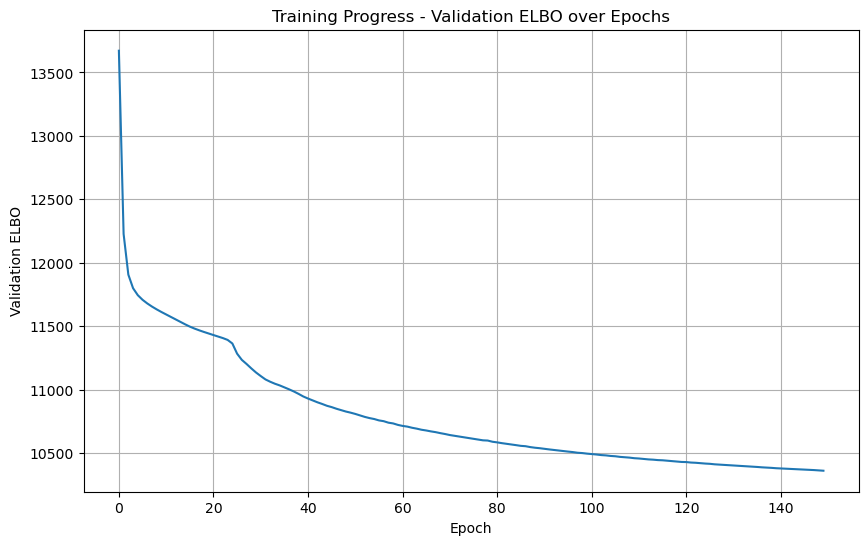

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(vae_ref.history_['elbo_validation'].index, vae_ref.history_['elbo_validation'].values)
plt.xlabel('Epoch')
plt.ylabel('Validation ELBO')
plt.title('Training Progress - Validation ELBO over Epochs')
plt.grid(True)
plt.show()

In [13]:
adata_ntc.obsm["X_scVI"] = vae_ref.get_latent_representation()

In [14]:
rsc.pp.neighbors(adata_ntc, n_neighbors=100, use_rep='X_scVI')
rsc.tl.umap(adata_ntc)

In [15]:
rsc.get.anndata_to_GPU(adata_ntc)
rsc.pp.normalize_total(adata_ntc)
rsc.pp.log1p(adata_ntc)

In [16]:
rsc.get.anndata_to_CPU(adata_ntc)

In [17]:
adata_ntc.write_h5ad(f'{datadir}/{experiment_name}.NTC_subsample.scVI.h5ad')


## Visualize embeddings

In [18]:
adata_ntc = sc.read_h5ad(f'{datadir}/{experiment_name}.NTC_subsample.scVI.h5ad')

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


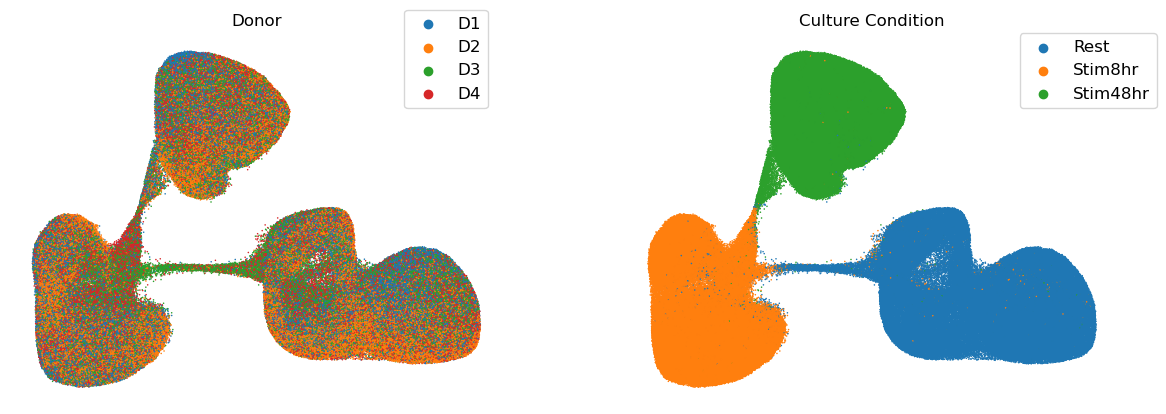

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


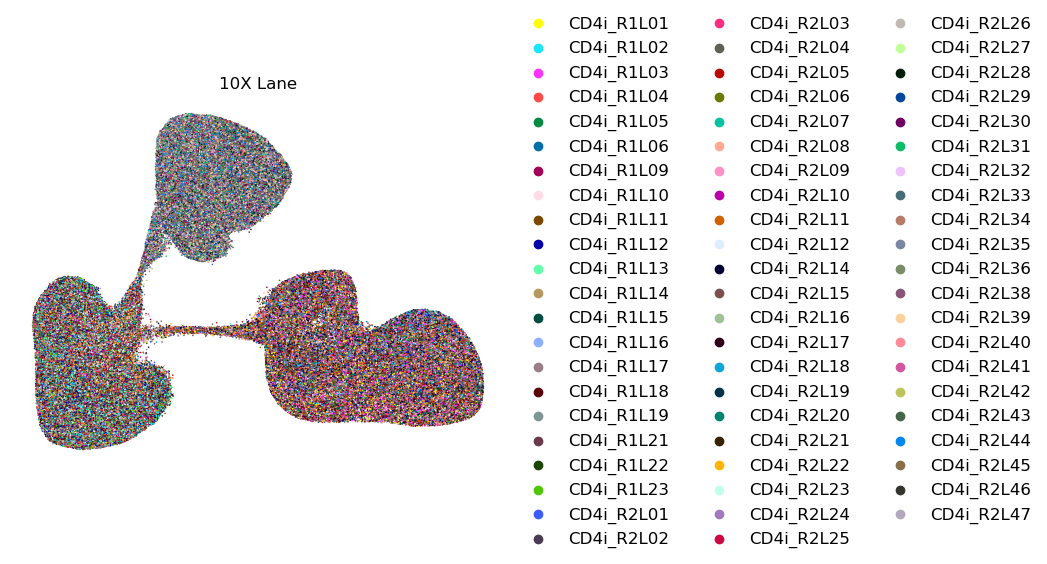

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


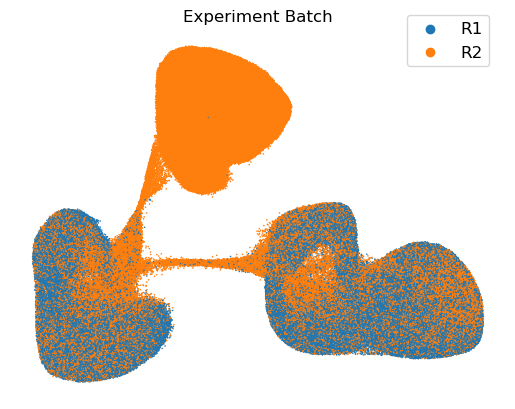

In [19]:
np.random.seed(1)
random_indices = np.random.permutation(list(range(adata_ntc.shape[0])))
sc.pl.umap(adata_ntc[random_indices, :], color=['donor_id', 'culture_condition'], s=5, frameon=False, 
           legend_loc=(0.8, 0.8), legend_fontsize=12, title=['Donor', 'Culture Condition'])
sc.pl.umap(adata_ntc[random_indices, :], color='lane_id', wspace=0.5, s=5, frameon=False,
           legend_loc='right margin', legend_fontsize=12, title='10X Lane')  
sc.pl.umap(adata_ntc[random_indices, :], color='experiment_batch', wspace=0.5, s=5, frameon=False,
           legend_loc=(0.8, 0.9), legend_fontsize=12, title='Experiment Batch')

In [21]:
TCELL_MARKERS_URL = 'https://docs.google.com/spreadsheets/d/1NSjrMofwd7etOJVvqHXFMNV0--gjzg8BzHMWGxK7SUI'

def load_Tcell_markers(adata: anndata.AnnData):
    Tcell_markers = pd.read_csv(f'{TCELL_MARKERS_URL}/export?format=csv')
    Tcell_markers = Tcell_markers[Tcell_markers['gene_name'].isin(adata.var['gene_name'])]
    Tcell_markers['state_program_name'] = Tcell_markers['state_program_name'].astype('category').cat.reorder_categories(Tcell_markers.state_program_name.unique())
    markers_dict = Tcell_markers.groupby('state_program_name')['gene_name'].apply(list).to_dict()
    return markers_dict

tcell_markers = load_Tcell_markers(adata_ntc)

/tmp/ipykernel_3487597/1243377815.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  markers_dict = Tcell_markers.groupby('state_program_name')['gene_name'].apply(list).to_dict()


In [22]:
adata_ntc.var_names = adata_ntc.var['gene_name']

In [23]:
adata_ntc.obs['sample_id'] = adata_ntc.obs['culture_condition'].astype(str) + ' - ' + adata_ntc.obs['donor_id'].astype(str)

In [24]:
tcell_markers = {
'General': ['CD3D', 'CD4', 'CD8A'],
 'Naive': [ 'LEF1', 'TCF7'],
 'Effector': ['IL2RA', 'IL2RB', 'CTLA4', 'TNFRSF18', 'TBX21', 'IFNG',  'TNF', 'GATA3', 'IL4', 'IL5', 'IL13', 'IL21'],
 'Treg': ['FOXP3', 'IL10'],
 'Cytotoxic': ['NKG7', 'PRF1', 'GZMB'],
 'Cycling': ['MKI67', 'PCNA', 'MCM7'],
}

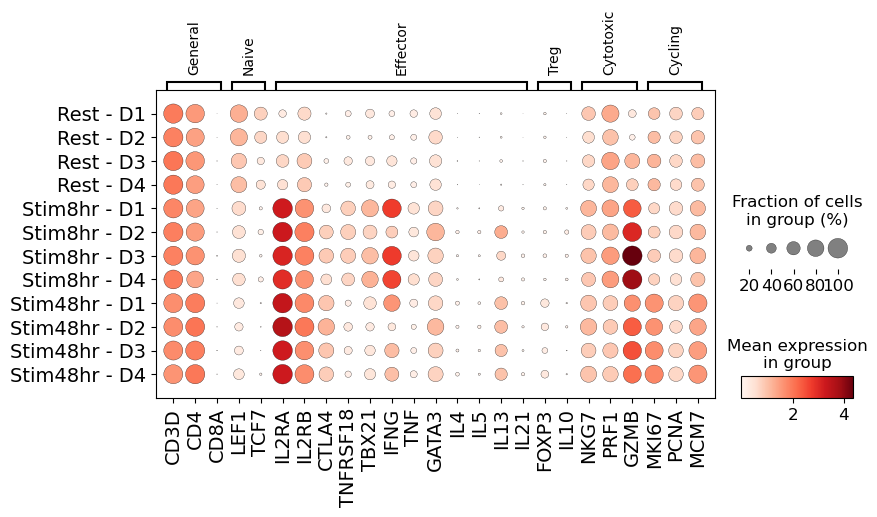

In [25]:
pl = sc.pl.DotPlot(adata_ntc, tcell_markers, groupby='sample_id', figsize=(9,4))
axes = pl.get_axes()
axes['mainplot_ax'].tick_params(axis='x', labelsize=14)
axes['mainplot_ax'].tick_params(axis='y', labelsize=14)
axes['color_legend_ax'].tick_params(labelsize=12)
axes['color_legend_ax'].title.set_size(12)
axes['size_legend_ax'].tick_params(labelsize=12)
axes['size_legend_ax'].title.set_size(12)

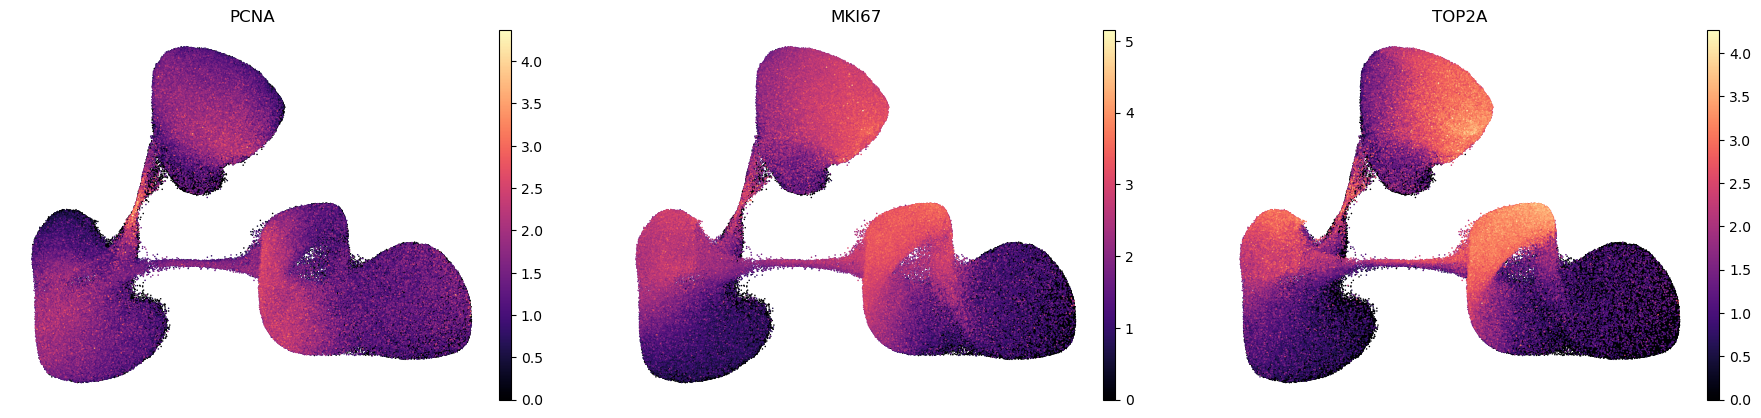

In [28]:

cc_genes = [
    'PCNA',
    'MKI67',
    'TOP2A'
]
sc.pl.umap(adata_ntc[random_indices, :], color=cc_genes,  cmap='magma', s=5, frameon=False, 
           legend_loc=(0.8, 0.8), legend_fontsize=12)